# EDA

#### Dependencies

In [2]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pm4py.objects.log.importer.xes import importer as xes_importer
from IPython.display import display
import textwrap

#### Event Log Import

In [3]:
file_path = r"C:\Users\compt\Desktop\Process Mining\InternationalDeclarations.xes"
log = xes_importer.apply(file_path)
print("Log loaded. Type:", type(log))

c:\Users\compt\AppData\Local\Programs\Python\Python310\lib\site-packages\pm4py\util\dt_parsing\parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

Log loaded. Type: <class 'pm4py.objects.log.obj.EventLog'>


# 1. Basic Log Information
## 1.1 Total Traces and Events

In [4]:
num_traces = len(log)
num_events = sum(len(trace) for trace in log)
print(f"Total number of traces: {num_traces}")
print(f"Total number of events: {num_events}")

Total number of traces: 6449
Total number of events: 72151


## 1.2 Events per Trace Distribution


Descriptive Statistics: Number of Events per Trace
count    6449.000000
mean       11.187936
std         2.740883
min         3.000000
25%        10.000000
50%        10.000000
75%        13.000000
max        27.000000
dtype: float64


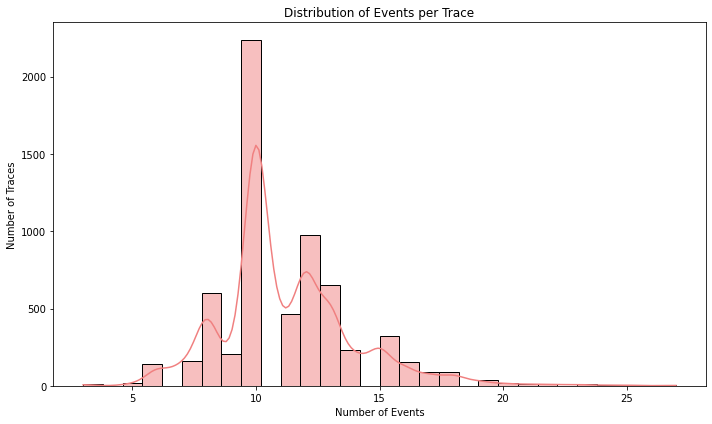

In [5]:
events_per_trace = [len(trace) for trace in log]
events_series = pd.Series(events_per_trace)

print("\nDescriptive Statistics: Number of Events per Trace")
print(events_series.describe())

plt.figure(figsize=(10, 6))
sns.histplot(events_series, bins=30, kde=True, color='lightcoral')
plt.title("Distribution of Events per Trace")
plt.xlabel("Number of Events")
plt.ylabel("Number of Traces")
plt.tight_layout()
plt.show()

## 1.3 Event Repetition per Trace


Descriptive Statistics: Event Repetitions per Trace
count    6449.000000
mean        0.471236
std         1.146585
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.000000
dtype: float64


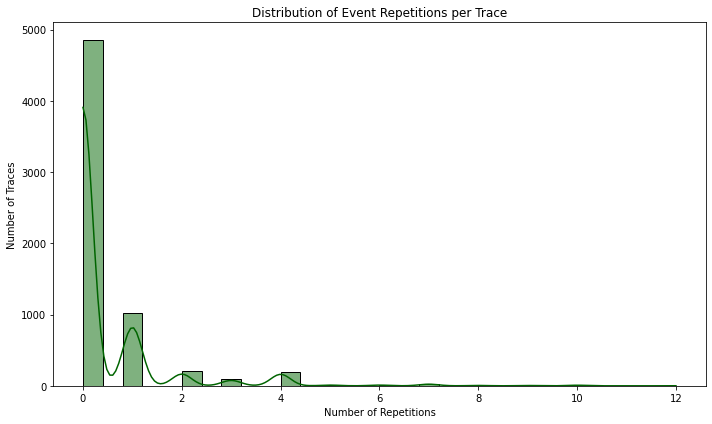

In [ ]:
repetitions = []
for trace in log:
    event_names = [event["concept:name"] for event in trace]
    unique_events = set(event_names)
    repetition_count = len(event_names) - len(unique_events)
    repetitions.append(repetition_count)

repetition_series = pd.Series(repetitions)

print("\nDescriptive Statistics: Event Repetitions per Trace")
print(repetition_series.describe())

plt.figure(figsize=(10, 6))
sns.histplot(repetition_series, bins=30, kde=True, color='darkgreen')
plt.title("Distribution of Event Repetitions per Trace")
plt.xlabel("Number of Repetitions")
plt.ylabel("Number of Traces")
plt.tight_layout()
plt.show()

# 2. Trace Information
## 2.1 Trace Duration


Descriptive Statistics: Case Duration Summary (in hours):
count     6449.000000
mean      2074.921188
std       1880.424687
min        161.519722
25%        914.893056
50%       1585.320833
75%       2499.019167
max      17808.000000
dtype: float64


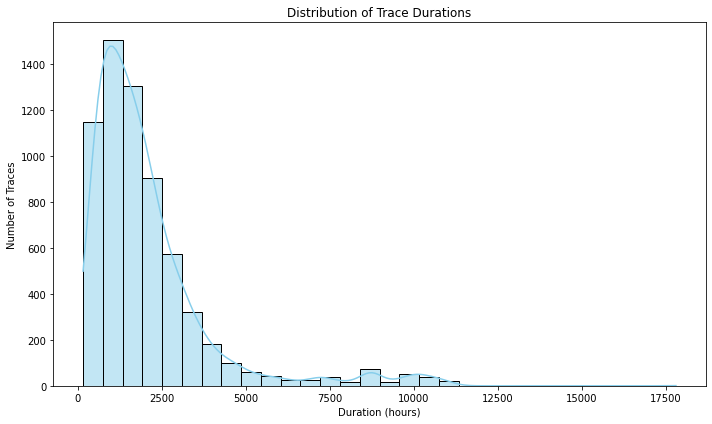

In [ ]:
durations = []
for trace in log:
    first_event = trace[0] 
    last_event = trace[-1] 
    
    if "time:timestamp" in first_event and "time:timestamp" in last_event:
        start_time = first_event["time:timestamp"]
        end_time = last_event["time:timestamp"]
        duration_hours = (end_time - start_time).total_seconds() / 3600 
        durations.append(duration_hours)

duration_series = pd.Series(durations)

print("\nDescriptive Statistics: Case Duration Summary (in hours):")
print(duration_series.describe())

plt.figure(figsize=(10, 6))
sns.histplot(duration_series, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Trace Durations")
plt.xlabel("Duration (hours)")
plt.ylabel("Number of Traces")
plt.tight_layout()
plt.show()

## 2.2 Trace Attributes

### 2.2.1 Trace Attribute Data Types

In [ ]:
first_trace = log[0]
attribute_info = []
for key, value in first_trace.attributes.items():
    attribute_info.append({
        "Attribute Key": key,
        "Data Type": str(type(value).__name__)
    })

df_attributes = pd.DataFrame(attribute_info)

styled_df = df_attributes.style.set_properties(**{
    'text-align': 'left'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td:nth-child(2)', 'props': [('text-align', 'center')]}  
]).hide(axis="index")  

display(styled_df)

Attribute Key,Data Type
Permit travel permit number,str
DeclarationNumber,str
Amount,float
RequestedAmount,float
Permit TaskNumber,str
Permit BudgetNumber,str
OriginalAmount,float
Permit ProjectNumber,str
concept:name,str
Permit OrganizationalEntity,str


### 2.2.2 Trace Float Attributes 

Attribute,count,mean,std,min,25%,50%,75%,max
Amount,6449.000000,766.881312,829.460046,0.000000,202.455244,509.068279,1045.575874,10765.935510
RequestedAmount,6449.000000,766.881312,829.460046,0.000000,202.455244,509.068279,1045.575874,10765.935510
OriginalAmount,6449.000000,766.881312,829.460046,0.000000,202.455244,509.068279,1045.575874,10765.935510
Permit RequestedBudget,6449.000000,1240.755666,1145.936822,0.000000,480.526586,923.081315,1641.673172,11112.385148
AdjustedAmount,6449.000000,766.896894,829.446580,0.000000,202.455244,509.068279,1045.575874,10765.935510


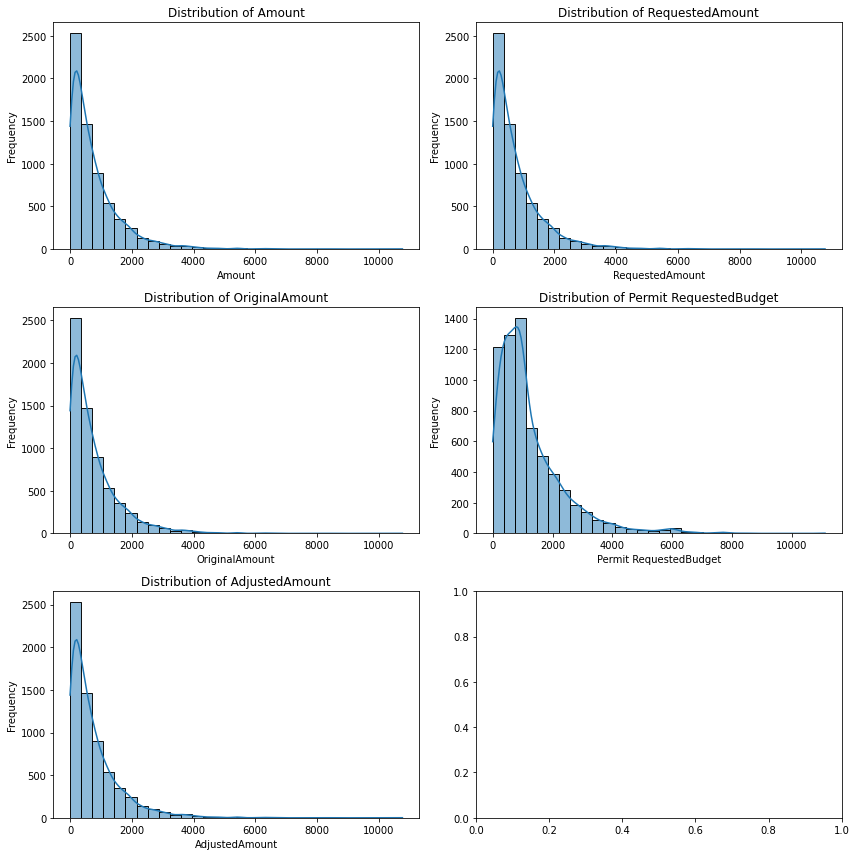

In [ ]:
float_attributes = ["Amount", "RequestedAmount", "OriginalAmount", "Permit RequestedBudget", "AdjustedAmount"]


numerical_data = {attr: [] for attr in float_attributes}
for trace in log:
    for attr in float_attributes:
        if attr in trace.attributes:
            numerical_data[attr].append(float(trace.attributes[attr]))

df_numerical = pd.DataFrame(numerical_data)

df_stats = df_numerical.describe().T
df_stats["Attribute"] = df_stats.index
df_stats = df_stats.reset_index(drop=True)
df_stats = df_stats[["Attribute"] + [col for col in df_stats.columns if col != "Attribute"]]

styled_df = df_stats.style.set_properties(**{
    'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td:nth-child(1)', 'props': [('text-align', 'Left')]}  
    ]).hide(axis="index")  

display(styled_df)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()  

for i, attr in enumerate(float_attributes):
    if attr in df_numerical and not df_numerical[attr].empty:
        sns.histplot(df_numerical[attr], bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {attr}")
        axes[i].set_xlabel(attr)
        axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


### 2.2.3 Trace String Attributes

In [ ]:
string_attributes = [
    "Permit travel permit number", "DeclarationNumber", "Permit TaskNumber", "Permit BudgetNumber",
    "Permit ProjectNumber", "Permit OrganizationalEntity", "travel permit number", "id", "Permit ID",
    "Permit id", "BudgetNumber", "Permit ActivityNumber"
]

string_data = {attr: [] for attr in string_attributes}
for trace in log:
    for attr in string_attributes:
        if attr in trace.attributes:
            value = trace.attributes[attr]
            if isinstance(value, str):
                string_data[attr].append(value)

df_strings = pd.DataFrame(string_data)

unknown_counts = {attr: (df_strings[attr] == "UNKNOWN").sum() for attr in string_attributes}
unique_counts = {attr: df_strings[attr].nunique() for attr in string_attributes}

average_repetitions = {}
std_repetitions = {}

for attr in string_attributes:
    value_counts = df_strings[attr].value_counts()
    if len(value_counts) > 0:
        average_repetitions[attr] = value_counts.mean() 
        std_repetitions[attr] = value_counts.std() 
    else:
        average_repetitions[attr] = 0
        std_repetitions[attr] = 0

df_summary = pd.DataFrame({
    "Attribute": string_attributes,
    "UNKNOWN Count": [unknown_counts[attr] for attr in string_attributes],
    "Unique Values Count": [unique_counts[attr] for attr in string_attributes],
    "Avg Repetitions per Unique Value": [average_repetitions[attr] for attr in string_attributes],
    "Std Dev of Repetitions": [std_repetitions[attr] for attr in string_attributes]
})

styled_df = df_summary.style.set_properties(**{
    'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td:nth-child(1)', 'props': [('text-align', 'Left')]}  
    ]).hide(axis="index")  

display(styled_df)


Attribute,UNKNOWN Count,Unique Values Count,Avg Repetitions per Unique Value,Std Dev of Repetitions
Permit travel permit number,23,5596,1.152430,6.012394
DeclarationNumber,260,6190,1.041842,3.291959
Permit TaskNumber,2340,6,1074.833333,1737.417557
Permit BudgetNumber,0,207,31.154589,54.080893
Permit ProjectNumber,2333,825,7.816970,82.791859
Permit OrganizationalEntity,0,27,238.851852,397.291184
travel permit number,0,6033,1.068954,0.452907
id,0,6449,1.000000,0.000000
Permit ID,0,6028,1.069841,0.453879
Permit id,0,5608,1.149964,5.999329


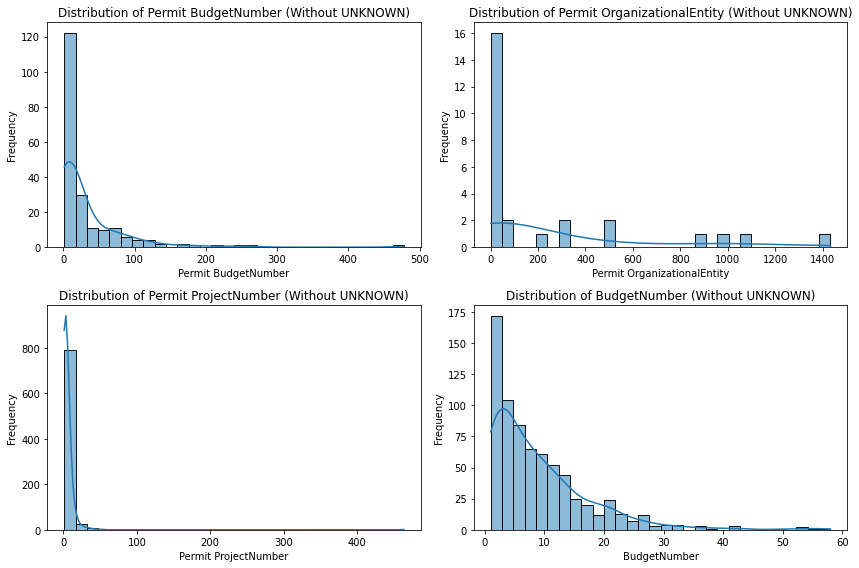

In [ ]:
df_strings_filtered = df_strings.map(lambda x: x if x != "UNKNOWN" else None)

attributes_to_plot = ["Permit BudgetNumber", "Permit OrganizationalEntity", 
                      "Permit ProjectNumber", "BudgetNumber"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  

for i, attr in enumerate(attributes_to_plot):
    if attr in df_strings_filtered:
        value_counts = df_strings_filtered[attr].value_counts()
        sns.histplot(value_counts, bins=30, kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {attr} (Without UNKNOWN)")
        axes[i].set_xlabel(attr)
        axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# 3. Event Information

### 3.1 Event Frequencies and Data Types

In [25]:
activities = []
activity_types = {}

for trace in log:
    for event in trace:
        activity_name = event.get("concept:name", "UNKNOWN")
        activities.append(activity_name)

        if activity_name not in activity_types:
            activity_types[activity_name] = type(activity_name).__name__

activity_counts = pd.Series(activities).value_counts()
activity_data = pd.DataFrame({
    "Activity": activity_counts.index,
    "Frequency": activity_counts.values,
    "Data Type": [activity_types[act] for act in activity_counts.index]
})

unique_activities = len(activity_counts)
print(f"\nNumber of unique activities: {unique_activities}")

styled_df = activity_data.style.set_properties(**{
    'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td:nth-child(1)', 'props': [('text-align', 'Left')]}  
    ]).hide(axis="index")  

display(styled_df) 


Number of unique activities: 34


Activity,Frequency,Data Type
Declaration SUBMITTED by EMPLOYEE,8099,str
Start trip,6449,str
End trip,6449,str
Permit SUBMITTED by EMPLOYEE,6255,str
Payment Handled,6187,str
Request Payment,6183,str
Declaration FINAL_APPROVED by SUPERVISOR,6039,str
Permit FINAL_APPROVED by SUPERVISOR,5381,str
Declaration APPROVED by ADMINISTRATION,5037,str
Permit APPROVED by ADMINISTRATION,4839,str


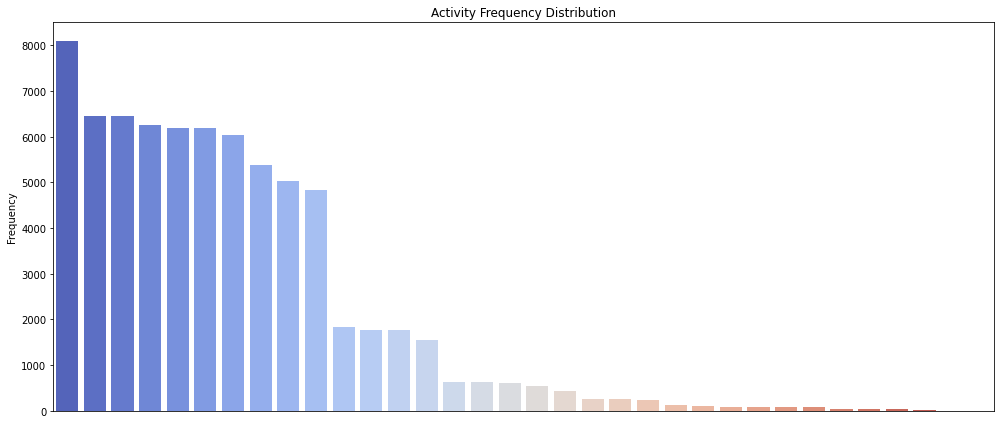

In [26]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x=activity_counts.index, 
    y=activity_counts.values, 
    hue=activity_counts.index, 
    palette="coolwarm",
    dodge=False
)

plt.title("Activity Frequency Distribution")
plt.xlabel("")  
plt.ylabel("Frequency")

ax.set_xticks([])
ax.set_xticklabels([])

plt.tight_layout()
plt.show()

### 3.2 Start and End Events

In [27]:
start_activities = [trace[0]["concept:name"] for trace in log]
end_activities = [trace[-1]["concept:name"] for trace in log]

start_counts = pd.Series(start_activities).value_counts().reset_index()
end_counts = pd.Series(end_activities).value_counts().reset_index()

start_counts.columns = ["Start Activity", "Frequency"]
end_counts.columns = ["End Activity", "Frequency"]

styled_df = start_counts.style.set_properties(**{
    'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td:nth-child(1)', 'props': [('text-align', 'Left')]}  
    ]).hide(axis="index")  

display(styled_df)

styled_df = end_counts.style.set_properties(**{
    'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td:nth-child(1)', 'props': [('text-align', 'Left')]}  
    ]).hide(axis="index")  

display(styled_df)

Start Activity,Frequency
Permit SUBMITTED by EMPLOYEE,5294
Start trip,740
Declaration SUBMITTED by EMPLOYEE,407
Declaration SAVED by EMPLOYEE,8


End Activity,Frequency
Payment Handled,5646
End trip,593
Declaration REJECTED by EMPLOYEE,130
Declaration SAVED by EMPLOYEE,54
Declaration REJECTED by MISSING,11
Permit REJECTED by MISSING,8
Request Payment,3
Send Reminder,2
Declaration FINAL_APPROVED by SUPERVISOR,1
Declaration REJECTED by SUPERVISOR,1


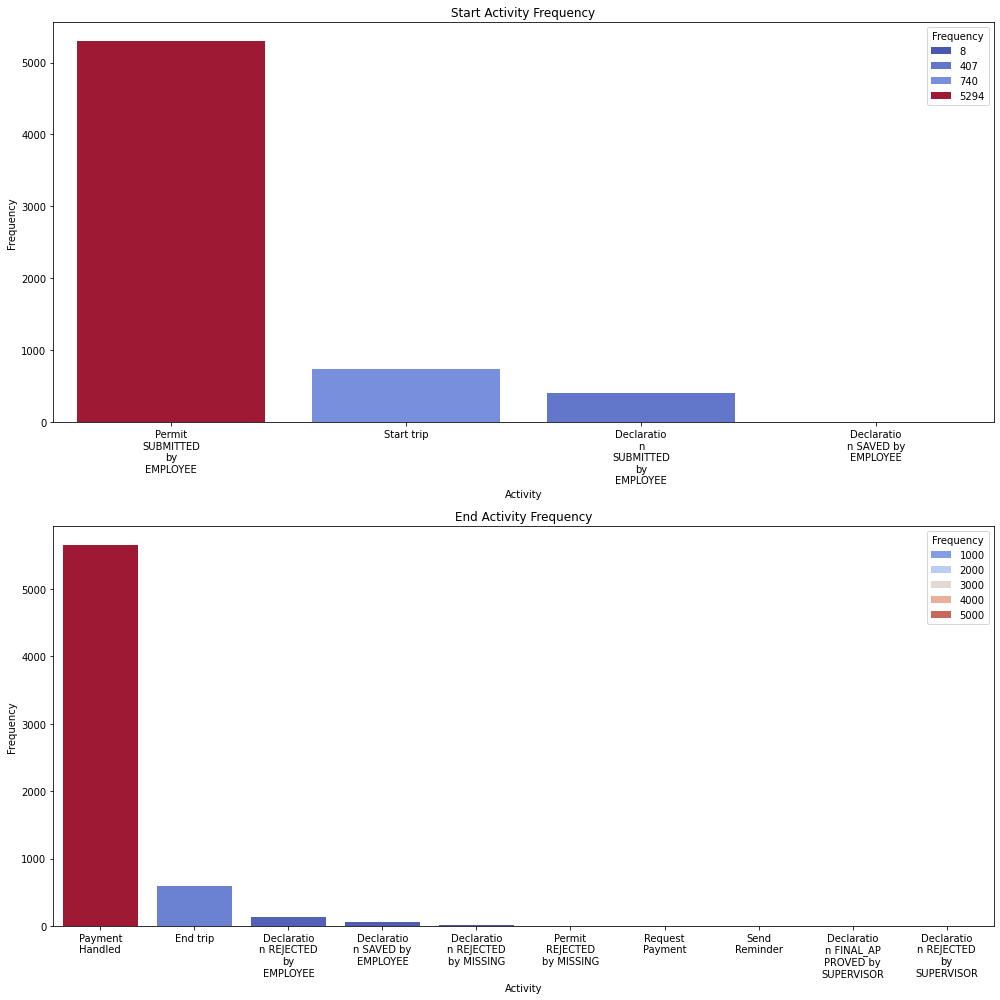

In [28]:
def wrap_labels(labels, width=10):
    return [textwrap.fill(label, width) for label in labels]

fig, axs = plt.subplots(2, 1, figsize=(14, 14))

sns.barplot(
    x=start_counts["Start Activity"], 
    y=start_counts["Frequency"], 
    ax=axs[0],
    hue=start_counts["Frequency"], 
    palette="coolwarm",
    dodge=False
    )

axs[0].set_title("Start Activity Frequency")
axs[0].set_xlabel("Activity")
axs[0].set_ylabel("Frequency")
axs[0].set_xticks(range(len(start_counts["Start Activity"])))
axs[0].set_xticklabels(wrap_labels(start_counts["Start Activity"]), rotation=0)

sns.barplot(
    x=end_counts["End Activity"], 
    y=end_counts["Frequency"],
    ax=axs[1], 
    hue=end_counts["Frequency"], 
    palette="coolwarm",
    dodge=False
    )

axs[1].set_title("End Activity Frequency")
axs[1].set_xlabel("Activity")
axs[1].set_ylabel("Frequency")
axs[1].set_xticks(range(len(end_counts["End Activity"])))
axs[1].set_xticklabels(wrap_labels(end_counts["End Activity"]), rotation=0)

plt.tight_layout()
plt.show()


### 3.3 Event Attributes

index,count
STAFF MEMBER,59347
SYSTEM,12804


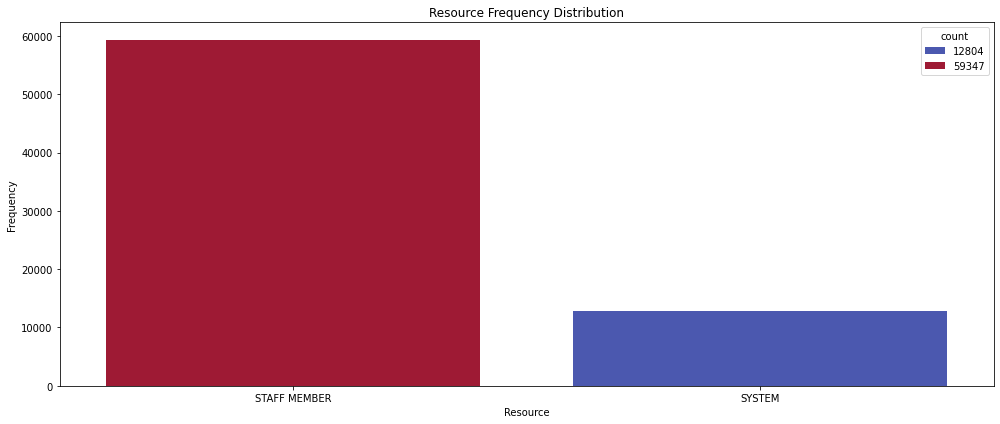

index,count
EMPLOYEE,29338
UNDEFINED,12804
SUPERVISOR,12535
ADMINISTRATION,11508
BUDGET OWNER,3668
PRE_APPROVER,1255
DIRECTOR,897
MISSING,146


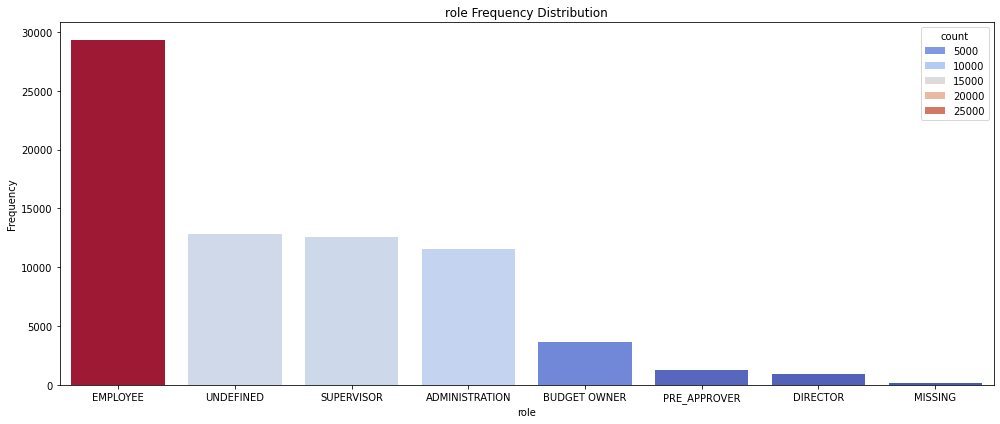

In [29]:
resources = []
for trace in log:
    for event in trace:
        resources.append(event.get("org:resource", "UNKNOWN"))

resources_counts = pd.Series(resources).value_counts().reset_index()

styled_df = resources_counts.style.set_properties(**{
    'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td:nth-child(1)', 'props': [('text-align', 'Left')]}  
    ]).hide(axis="index")  

display(styled_df)

plt.figure(figsize=(14, 6))
sns.barplot(
    x=resources_counts["index"], 
    y=resources_counts["count"],
    hue=resources_counts["count"], 
    palette="coolwarm",
    dodge=False 
    )

plt.title("Resource Frequency Distribution")
plt.xlabel("Resource")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

roles = []
for trace in log:
    for event in trace:
        roles.append(event.get("org:role", "UNKNOWN"))

roles_counts = pd.Series(roles).value_counts().reset_index()

styled_df = roles_counts.style.set_properties(**{
    'text-align': 'center'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td:nth-child(1)', 'props': [('text-align', 'Left')]}  
    ]).hide(axis="index")  

display(styled_df)

plt.figure(figsize=(14, 6))
sns.barplot(
    x=roles_counts["index"], 
    y=roles_counts["count"],
    hue=roles_counts["count"], 
    palette="coolwarm",
    dodge=False 
    )

plt.title("role Frequency Distribution")
plt.xlabel("role")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()